## NASDAQ Stock long Short Contest 
Working through the example given by quantiacs

In [77]:
import xarray as xr
import nbformat
import numpy as np

import qnt
import qnt.ta as qnta
import qnt.data as qndata
import qnt.output as qnout
import qnt.stats as qns

In [51]:
# load data 
data = qndata.stocks.load_ndx_data(min_date="2005-06-01");
# data = xr.open_dataset("data/stocks_2005.nc")

fetched chunk 1/5 0s
fetched chunk 2/5 0s
fetched chunk 3/5 0s
fetched chunk 4/5 0s
fetched chunk 5/5 0s
Data loaded 1s


### Example basic model from website
Performs unreasonably terribly. Let's see if we can do better?

In [6]:
close     = data.sel(field="open")
is_liquid = data.sel(field="is_liquid")
sma_slow  = qnta.sma(close, 200)
sma_fast  = qnta.sma(close, 20)
weights   = xr.where(np.abs(sma_slow) < sma_fast, 1, -1)
weights   = weights * is_liquid

weights = qnout.clean(weights, data, "stocks_nasdaq100")

# calc stats
stats = qns.calc_stat(data, weights.sel(time=slice("2006-01-01", None)))
display(stats.to_pandas().tail())

# graph
performance = stats.to_pandas()["equity"]
import qnt.graph as qngraph

qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2022-10-07,1.003363,0.021213,0.137012,-0.188109,-0.407992,0.001463,0.000200,-0.495798,230.0,0.032403,110.516568
2022-10-10,1.012389,0.008996,0.137014,-0.180805,-0.407992,0.005366,0.000735,-0.529412,230.0,0.032405,110.503904
2022-10-11,1.020986,0.008492,0.137013,-0.173849,-0.407992,0.009051,0.001240,-0.529412,230.0,0.032411,110.507687
2022-10-12,1.021397,0.000402,0.136997,-0.173517,-0.407992,0.009225,0.001264,-0.529412,230.0,0.032407,110.507687
2022-10-13,1.010491,-0.010678,0.137006,-0.182342,-0.407992,0.004545,0.000623,-0.529412,230.0,0.032405,115.604141


In [7]:
weights = weights.sel(time=slice("2006-01-01",None))

qnout.check(weights, data, "stocks_nasdaq100")

Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2022-10-13
Sharpe Ratio = 0.004544636537508778


ERROR! The Sharpe Ratio is too low. 0.004544636537508778 < 1
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 1.


Check correlation.


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'
Correlation check failed.


In [ ]:
# select multiple assets simultaneously
data.sel(asset = ["NAS:AAL", "NAS:AAPL"])[-1]

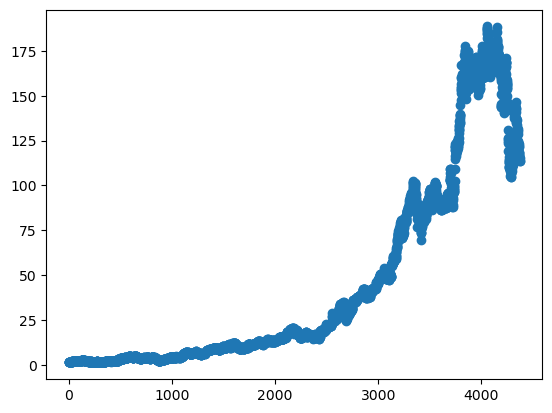

In [68]:
import matplotlib.pyplot as plt
ar = np.array(data.sel(asset = "NAS:AMZN", field = "high"))
plt.scatter(np.arange(len(ar)), ar)

### Build simple strategy that only holds fixed stocks

In [84]:
stocks = ["NAS:AMZN", "NAS:AAPL", "NAS:TSLA", "NAS:MSFT"]
ws = np.full((len(weights.time),len(stocks)), 1)
weights2 = xr.DataArray(ws, dims = ["time", "asset"], coords = [weights.time, stocks])

# trade liquid stocks only 
weights2 = qnt.output.clean(weights2, data, "stocks_nasdaq100")

Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


In [85]:
# evaluate strategy
stats = qns.calc_stat(data, weights2.sel(time=slice("2006-01-01", None)))
display(stats.to_pandas().tail())

# graph
performance = stats.to_pandas()["equity"]
import qnt.graph as qngraph

qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")
qnout.check(weights2, data, "stocks_nasdaq100")

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2022-10-07,61.989184,-0.048991,0.286263,-0.317672,-0.569953,0.975999,0.279393,1.0,4.0,0.018821,1906.0
2022-10-10,61.562437,-0.006884,0.286236,-0.322369,-0.569953,0.973989,0.278791,1.0,4.0,0.018821,1906.0
2022-10-11,60.506432,-0.017153,0.286237,-0.333993,-0.569953,0.969115,0.277397,1.0,4.0,0.018818,1906.0
2022-10-12,60.604567,0.001622,0.286203,-0.332913,-0.569953,0.969403,0.277446,1.0,4.0,0.018817,1906.0
2022-10-13,61.825233,0.020141,0.286207,-0.319477,-0.569953,0.974443,0.278892,1.0,4.0,0.018825,3378.4


Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2022-10-13
Sharpe Ratio = 0.9744426578040422


ERROR! The Sharpe Ratio is too low. 0.9744426578040422 < 1
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 1.


Check correlation.


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'
Correlation check failed.
